In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv

from PAUT_preprocessing.PAUT_acquisition import PAUT_acquisition

In [160]:
# get the PAUT acquisition data

name = "FA3569081_SH83_LF45°"
acq_obj = PAUT_acquisition(
    dirpath = os.path.join('C:/users/dalmonte/data/ADAMUS/DFKI PAUT', name, name, '45° 2195_'),
    labelpath = 'C:/users/dalmonte/data/ADAMUS/labelling files/240312_M_Adamus_Anzeigen_DFKI_SUB_refined.csv',
)

# get labels
labels = acq_obj.get_labelsFromCSV()
print(f"Found {len(labels)} labelled defects")
print(f"X limits [mm]: ({labels["x Start"].values[0]} : {labels["x Ende"].values[0]})")

Found 25 labelled defects
X limits [mm]: (0.0 : 4992.0)


In [161]:
# get ascans
ascans = acq_obj.compose_Ascans(valid=False)
print(f"ascans shape: {ascans.shape}")

# get bscans
bscans = []
for x in range(ascans.shape[1]):
      bscans.append(acq_obj.extract_Bscan(ascans, 
                                          idx = x,
                                          correction = True
                                          )
                  )
bscans = np.array(bscans)
print(f"bscans shape: {bscans.shape}")

# get ncrops
ncrops = []
for b in bscans:
      ncrops.append(acq_obj.extract_ncrop(b))
ncrops = np.sqrt(np.array(ncrops))*10
print(f"ncrops shape: {ncrops.shape}")
ncrops_max = np.quantile(ncrops, (1-1e-5))
print(f"ncrops max: {ncrops_max}")


ascans shape: (115, 6084, 244)
bscans shape: (6084, 244, 1227)
ncrops shape: (6084, 200, 340)
ncrops max: 82.41811469839922


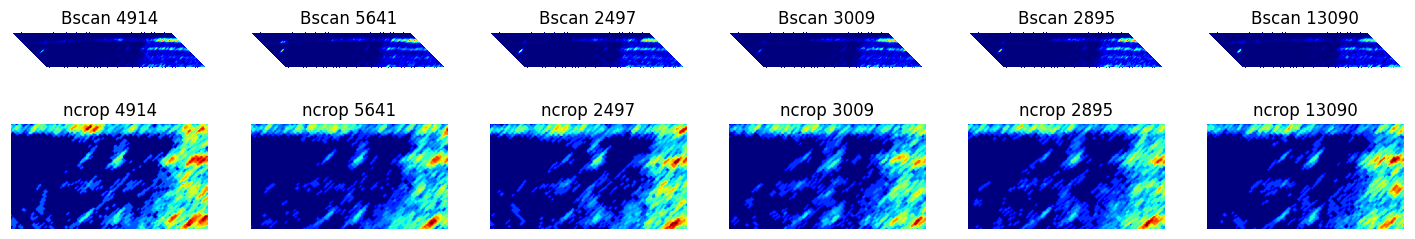

In [131]:
# plot bscans and ncrops examples
fig, ax = plt.subplots(2, 6, figsize=(18, 3))
for i, idx in enumerate(np.random.randint(0, len(bscans), 6)):
      ax[0, i].imshow(bscans[idx], cmap='jet')
      ax[0, i].set_title(f"Bscan {idx}"); ax[0, i].axis('off')
      ax[1, i].imshow(ncrops[idx], cmap='jet')
      ax[1, i].set_title(f"ncrop {idx}"); ax[1, i].axis('off')


Text(0.5, 1.0, 'median ncrop histogram')

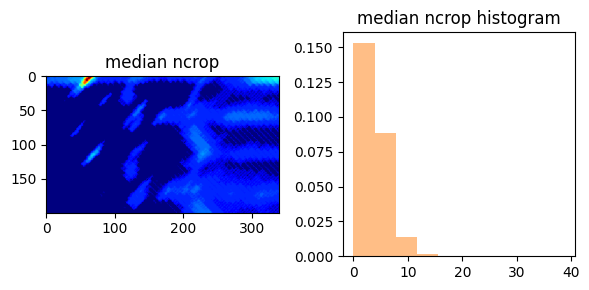

In [162]:
# median ncrop
median_ncrop = np.median(ncrops, axis=0)
fig, ax = plt.subplots(1, 2, figsize=(6, 3), tight_layout=True)
ax[0].imshow(median_ncrop, cmap='jet')
ax[0].set_title(f"median ncrop")
ax[1].hist(median_ncrop.flatten(), bins=10, color='tab:orange', alpha=0.5, density=True)
ax[1].set_title(f"median ncrop histogram")


In [173]:
# create multichannel nugget crops
median_channel = ((cv.GaussianBlur(median_ncrop, None, 2, 2)/(0.5*ncrops_max))*255).astype(int)
mch_ncrops = []
for i, n in enumerate(ncrops):
    ncrops_ch1 = ((n/ncrops_max)*255).astype(int)
    ncrops_ch2 = ((n/ncrops_max)*255).astype(int)

    mch_ncrops.append(np.dstack((median_channel, ncrops_ch1, ncrops_ch2)))

mch_ncrops = np.array(mch_ncrops)
print(f"mch_ncrops shape: {mch_ncrops.shape}")


mch_ncrops shape: (6084, 200, 340, 3)


In [174]:
# get defects coordinates
xi = (acq_obj.xmm_to_idx(labels['X-Pos.'].values))
xf = (acq_obj.xmm_to_idx(labels['X-Pos.'].values+labels['Länge l'].values))
yi = (acq_obj.ymm_to_idx(labels['Y-Pos.'].values))
yf = (acq_obj.ymm_to_idx(labels['Y-Pos.'].values+labels['Breite b'].values))
zi = (acq_obj.tmm_to_idx(labels['Z-Pos.'].values))
zf = (acq_obj.tmm_to_idx(labels['Z-Pos.'].values+labels['Tiefe t'].values))

xl = (xf - xi).astype(int)
yl = (yf - yi).astype(int)
zl = (zf - zi).astype(int)

# get nugget coordinates wrt full bscan
top_nugget = acq_obj.tmm_to_idx(acq_obj.ncrop["top_mm"])
left_nugget = acq_obj.ymm_to_idx(acq_obj.ncrop["left_mm"])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


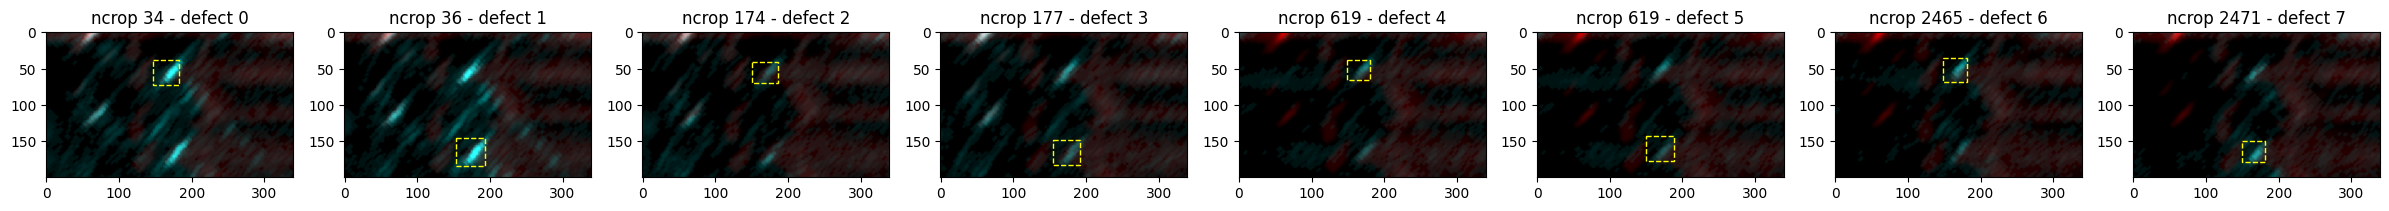

In [176]:
# plot defects
N = np.min([len(labels), 8])
M = 8

idxs_defects = (xi+xf)//2

fig, ax = plt.subplots(1, N, figsize=(N*3, 3), tight_layout=True)
for i in range(N):
    ax[i].imshow(mch_ncrops[idxs_defects[i]])
    # draw a rectangle around the defect
    rect = plt.Rectangle([yi[i]-left_nugget, zi[i]-top_nugget], yl[i], zl[i],
                         edgecolor='yellow', linewidth=1, linestyle="dashed", facecolor='none')
    ax[i].add_patch(rect)
    ax[i].set_title(f"ncrop {idxs_defects[i]} - defect {i}")
